# Board Game Rating Prediction

The dataset was obtained [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2022/2022-01-25/readme.md) with the original source coming from [Kaggle](https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews?select=2022-01-08.csv). The data was collected from [BoardGameGeek](https://boardgamegeek.com/).<br><br>
The dataset contains two files: one for information on the games related information and ratings from the website, and the other for information relating to the game and its descriptions. Our goal for this project is to create a machine learning model using information related to these board games that will predict on the target `average`: the average rating of a game. Therefore, our model will be a regression model.  
<br>
In this notebook, we will first read in the two data files and merge them. Then, we will examine the merged DataFrame and look for missing values or features that may not be useful and process them. Finally, we will create visualizations of tables or plots to examine the distribution of the target value as well as feature values. This will help us in estimating which features may be useful in the regression task.

In [1]:
import pandas as pd
import altair as alt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Reading in and cleaning the data

In [2]:
ratings = pd.read_csv("../data/raw/ratings.csv", header=1)
details = pd.read_csv("../data/raw/details.csv", header=1)

**Table 1: Examining at the fist few rows of the `ratings` file**

In [3]:
ratings.head()

,num,id,name,year,rank,average,bayes_average,users_rated,url,thumbnail
0,105,30549,Pandemic,2008,106,7.59,7.487,108975,/boardgame/30549/pandemic,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
1,189,822,Carcassonne,2000,190,7.42,7.309,108738,/boardgame/822/carcassonne,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
2,428,13,Catan,1995,429,7.14,6.970,108024,/boardgame/13/catan,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
3,72,68448,7 Wonders,2010,73,7.74,7.634,89982,/boardgame/68448/7-wonders,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...
4,103,36218,Dominion,2008,104,7.61,7.499,81561,/boardgame/36218/dominion,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...


**Table 2: Examining at the first few rows of the `details` file**

In [4]:
details.head()

,num,id,primary,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,...,boardgamefamily,boardgameexpansion,boardgameimplementation,boardgamedesigner,boardgameartist,boardgamepublisher,owned,trading,wanting,wishing
0,0,30549,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,45,...,"['Components: Map (Global Scale)', 'Components...",['Pandemic: Gen Con 2016 Promos – Z-Force Team...,"['Pandemic Legacy: Season 0', 'Pandemic Legacy...",['Matt Leacock'],"['Josh Cappel', 'Christian Hanisch', 'Régis Mo...","['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",168364,2508,625,9344
1,1,822,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,45,30,45,...,"['Cities: Carcassonne (France)', 'Components: ...","['20 Jahre Darmstadt Spielt', 'Apothecaries (f...","['The Ark of the Covenant', 'Carcassonne für 2...",['Klaus-Jürgen Wrede'],"['Doris Matthäus', 'Anne Pätzke', 'Chris Quill...","['Hans im Glück', '999 Games', 'Albi', 'Bard C...",161299,1716,582,7383
2,2,13,Catan,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,120,60,120,...,"['Animals: Sheep', 'Components: Hexagonal Tile...","['20 Jahre Darmstadt Spielt', 'Brettspiel Adve...","['Baden-Württemberg Catan', 'Catan Geographies...",['Klaus Teuber'],"['Volkan Baga', 'Tanja Donner', 'Pete Fenlon',...","['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...",167733,2018,485,5890
3,3,68448,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,30,...,"['Ancient: Babylon', 'Ancient: Egypt', 'Ancien...","['7 Wonders: Armada', '7 Wonders: Babel', '7 W...","['7 Wonders (Second Edition)', '7 Wonders Duel...",['Antoine Bauza'],"['Dimitri Chappuis', 'Miguel Coimbra', 'Etienn...","['Repos Production', 'ADC Blackfire Entertainm...",120466,1567,1010,12105
4,4,36218,Dominion,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,30,...,"['Crowdfunding: Wspieram', 'Game: Dominion', '...","['Ancient Times (fan expansion for Dominion)',...","['Dominion (Second Edition)', 'Het Koninkrijk ...",['Donald X. Vaccarino'],"['Matthias Catrein', 'Julien Delval', 'Tomasz ...","['Rio Grande Games', '999 Games', 'Albi', 'Bar...",106956,2009,655,8621


Since we do not need all the features, we will remove the ones that we will not use in the prediction task. From `ratings`, we remove everything except `id` and `average`, since we will need `id` to join the two dataframes and `average` is our target column. From details, we remove `num`, `primary`, `owned`, `trading`, `wanting`, and `wishing`. After dropping the columns, we will join the two dataframes on the `id` column.

In [5]:
ratings = ratings[["id", "average"]]
details = details.drop(columns=["num", "primary", "owned", "trading", "wanting", "wishing"])
boardgame_df = details.merge(ratings, on="id", how="left").drop(columns=["id"])

**Table 3: Examining the first few rows of the merged DataFrame**

In [6]:
boardgame_df.head()

,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,boardgamefamily,boardgameexpansion,boardgameimplementation,boardgamedesigner,boardgameartist,boardgamepublisher,average
0,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,45,8,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...",['Pandemic: Gen Con 2016 Promos – Z-Force Team...,"['Pandemic Legacy: Season 0', 'Pandemic Legacy...",['Matt Leacock'],"['Josh Cappel', 'Christian Hanisch', 'Régis Mo...","['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",7.59
1,Carcassonne is a tile-placement game in which ...,2000,2,5,45,30,45,7,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...","['Cities: Carcassonne (France)', 'Components: ...","['20 Jahre Darmstadt Spielt', 'Apothecaries (f...","['The Ark of the Covenant', 'Carcassonne für 2...",['Klaus-Jürgen Wrede'],"['Doris Matthäus', 'Anne Pätzke', 'Chris Quill...","['Hans im Glück', '999 Games', 'Albi', 'Bard C...",7.42
2,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,120,60,120,10,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...","['Animals: Sheep', 'Components: Hexagonal Tile...","['20 Jahre Darmstadt Spielt', 'Brettspiel Adve...","['Baden-Württemberg Catan', 'Catan Geographies...",['Klaus Teuber'],"['Volkan Baga', 'Tanja Donner', 'Pete Fenlon',...","['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...",7.14
3,You are the leader of one of the 7 great citie...,2010,2,7,30,30,30,10,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Drafting', 'Hand Management', 'Set Collectio...","['Ancient: Babylon', 'Ancient: Egypt', 'Ancien...","['7 Wonders: Armada', '7 Wonders: Babel', '7 W...","['7 Wonders (Second Edition)', '7 Wonders Duel...",['Antoine Bauza'],"['Dimitri Chappuis', 'Miguel Coimbra', 'Etienn...","['Repos Production', 'ADC Blackfire Entertainm...",7.74
4,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,30,13,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...","['Crowdfunding: Wspieram', 'Game: Dominion', '...","['Ancient Times (fan expansion for Dominion)',...","['Dominion (Second Edition)', 'Het Koninkrijk ...",['Donald X. Vaccarino'],"['Matthias Catrein', 'Julien Delval', 'Tomasz ...","['Rio Grande Games', '999 Games', 'Albi', 'Bar...",7.61


## Exploratory Data Analysis

**Table 4: Examining the datatype and missing values of the merged DataFrame**

In [7]:
boardgame_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21631 entries, 0 to 21630
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   description              21630 non-null  object 
 1   yearpublished            21631 non-null  int64  
 2   minplayers               21631 non-null  int64  
 3   maxplayers               21631 non-null  int64  
 4   playingtime              21631 non-null  int64  
 5   minplaytime              21631 non-null  int64  
 6   maxplaytime              21631 non-null  int64  
 7   minage                   21631 non-null  int64  
 8   boardgamecategory        21348 non-null  object 
 9   boardgamemechanic        20041 non-null  object 
 10  boardgamefamily          17870 non-null  object 
 11  boardgameexpansion       5506 non-null   object 
 12  boardgameimplementation  4862 non-null   object 
 13  boardgamedesigner        21035 non-null  object 
 14  boardgameartist       

Seeing that there are many missing values for `boardgameexpansion` and `boardgameimplementation`, we will drop those columns. Since the columns `description`, `boardgamecategory`, `boardgamemechanic`, `boardgamefamily`, `boardgameartist`, and `boardgamepublisher` also have some missing values in each column, we will drop the rows that contain missing values for those columns. This will also help reduce the overall size of the dataset so it is easier to work with.  
The list like values of `boardgamecategory`, `boardgamemechanic`, `boardgamefamily`, `boardgameartist`, and `boardgamepublisher` are being read in as strings by `read_csv`, so we will also need to process them to change them to actual lists.

In [8]:
boardgame_df = boardgame_df.drop(columns=["boardgameexpansion", "boardgameimplementation"])
boardgame_df = boardgame_df.dropna()
categorical_features = ["boardgamecategory", "boardgamemechanic", "boardgamefamily", "boardgameartist", "boardgamepublisher"]
for feat in categorical_features:
    boardgame_df[feat] = boardgame_df[feat].apply(literal_eval)

In [9]:
type(boardgame_df["boardgamemechanic"].loc[0]) == list

True

After clearning up the dataset, we can now split the dataset into a training and testing portion and perform EDA.

In [10]:
train_df, test_df = train_test_split(boardgame_df, test_size=0.5, random_state=42)

<br>

**Table 5: Showing non-missing values and types of each column.**

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6241 entries, 15682 to 10191
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   description         6241 non-null   object 
 1   yearpublished       6241 non-null   int64  
 2   minplayers          6241 non-null   int64  
 3   maxplayers          6241 non-null   int64  
 4   playingtime         6241 non-null   int64  
 5   minplaytime         6241 non-null   int64  
 6   maxplaytime         6241 non-null   int64  
 7   minage              6241 non-null   int64  
 8   boardgamecategory   6241 non-null   object 
 9   boardgamemechanic   6241 non-null   object 
 10  boardgamefamily     6241 non-null   object 
 11  boardgamedesigner   6241 non-null   object 
 12  boardgameartist     6241 non-null   object 
 13  boardgamepublisher  6241 non-null   object 
 14  average             6241 non-null   float64
dtypes: float64(1), int64(7), object(7)
memory usage: 7

After preprocessing the data, we have gotten rid of all rows with missing values. This makes it easier to create the model later on.

<br>

**Table 6: Information about distribution of features**

In [12]:
train_df.describe(include="all")

,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgameartist,boardgamepublisher,average
count,6241,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241.000000,6241,6241,6241,6241,6241,6241,6241.000000
unique,6236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2806,3617,4585,3698,4186,3928,NaN
top,An expansion to the creativity game Rory's Sto...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Wargame, World War II]",[Hexagon Grid],[Crowdfunding: Kickstarter],['(Uncredited)'],[(Uncredited)],[GMT Games],NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333,143,315,102,91,108,NaN
mean,NaN,2000.785772,1.928858,4.961224,112.418843,70.064253,112.418843,9.994873,NaN,NaN,NaN,NaN,NaN,NaN,6.676260
std,NaN,148.609226,0.682005,7.555549,428.695447,195.775608,428.695447,3.547431,NaN,NaN,NaN,NaN,NaN,NaN,0.826607
min,NaN,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.250000
25%,NaN,2005.000000,2.000000,2.000000,30.000000,20.000000,30.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.160000
50%,NaN,2013.000000,2.000000,4.000000,60.000000,45.000000,60.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.690000
75%,NaN,2017.000000,2.000000,5.000000,120.000000,60.000000,120.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,7.230000


From these tables, we can see that the features are a mix of numeric, categorical, and text features. There are missing values in some columns that will need to be handled. Furthermore, we note that the numeric features have varying scales in their range of values.

<br>

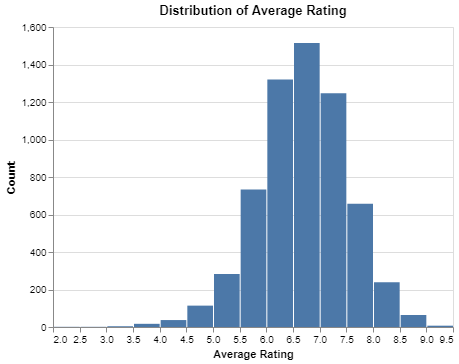

In [13]:
rating_plot = alt.Chart(
    train_df,
    title = "Distribution of Average Rating"
).mark_bar().encode(
    x = alt.X("average", bin=alt.Bin(maxbins=30), title="Average Rating"),
    y = alt.Y("count()", title="Count")
)
rating_plot

**Figure 1: Distribution of the average ratings of board games.**

It appears that most average ratings of board games are around 6-7, and the distribution resembles a bell shape. There are some ratings that are very high (9.31) and some very low (2.25), but values are somewhere in the midranges.

<br>

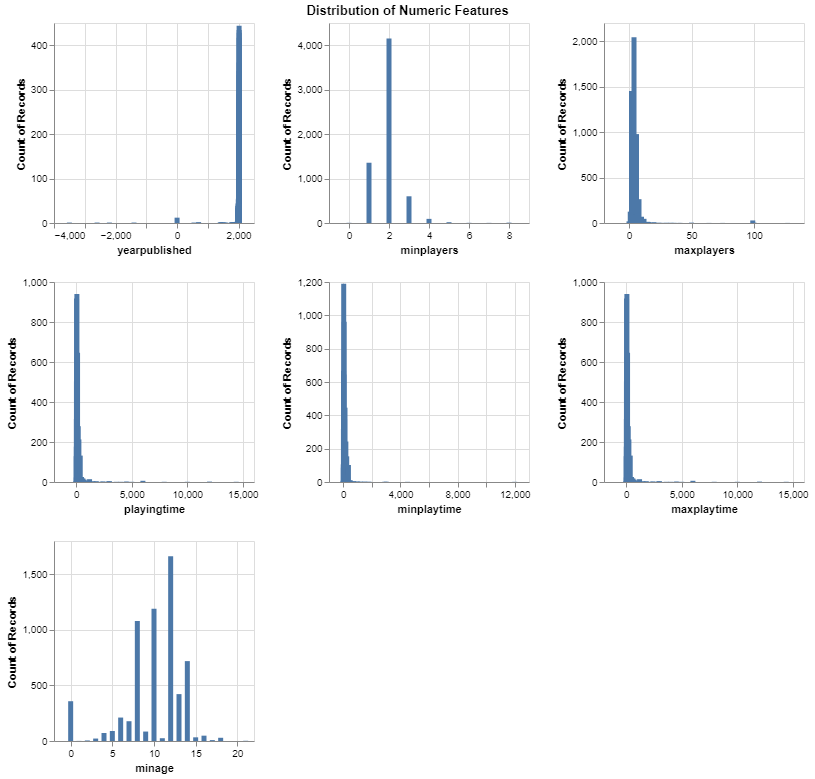

In [14]:
numeric_feats = train_df.select_dtypes(include="number").columns.tolist()[0:-1]
numeric_feats_bar_chart = alt.Chart(train_df).mark_bar().encode(
    x = alt.X(alt.repeat(), type="quantitative"),
    y = "count()"
).properties(
    width=200,
    height=200
).repeat(
    numeric_feats,
    columns=3
)
numeric_feats_bar_chart.properties(title = alt.TitleParams(text="Distribution of Numeric Features", anchor="middle"))

**Figure 2: Distribution of numeric features.**

Looking at the distribution of each numeric feature, we can see that most numeric features are heavily right skewed, such as with `maxplayers`, `playingtime`, `minplaytime`, and `maxplaytime`. This is mostly inline with expectations: most games are usually played with 2-8 players, and playing times usually range from 1-2 hours. The `yearpublished` feature seems to have some weird values that do not make sense, such as years in the negative range.

<br>

In [15]:
corr_matrix = train_df.corr('spearman').style.background_gradient()
corr_matrix

,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,average
yearpublished,1.000000,-0.210202,0.105070,-0.105236,-0.278300,-0.105236,0.074648,0.408366
minplayers,-0.210202,1.000000,0.236674,-0.129654,-0.039540,-0.129654,-0.091284,-0.246116
maxplayers,0.105070,0.236674,1.000000,-0.133306,-0.142949,-0.133306,-0.047632,-0.162838
playingtime,-0.105236,-0.129654,-0.133306,1.000000,0.890897,1.000000,0.439326,0.380509
minplaytime,-0.278300,-0.039540,-0.142949,0.890897,1.000000,0.890897,0.406683,0.255512
maxplaytime,-0.105236,-0.129654,-0.133306,1.000000,0.890897,1.000000,0.439326,0.380509
minage,0.074648,-0.091284,-0.047632,0.439326,0.406683,0.439326,1.000000,0.262100
average,0.408366,-0.246116,-0.162838,0.380509,0.255512,0.380509,0.262100,1.000000


**Figure 3: Correlation matrix of numeric features and target.**

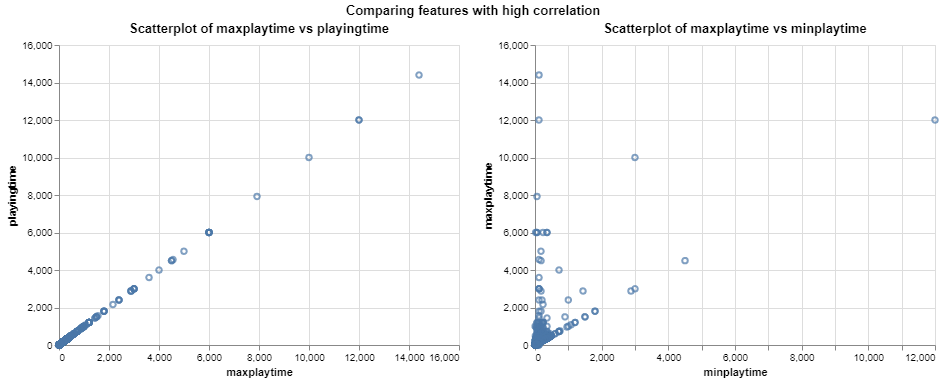

In [16]:
maxplaytime_vs_playingtime = alt.Chart(
    train_df,
    title = "Scatterplot of maxplaytime vs playingtime"
).mark_point().encode(
    x = alt.X("maxplaytime"),
    y = alt.Y("playingtime")
)
minplaytime_vs_maxplaytime = alt.Chart(
    train_df,
    title = "Scatterplot of maxplaytime vs minplaytime"
).mark_point().encode(
    x = alt.X("minplaytime"),
    y = alt.Y("maxplaytime")
)
(maxplaytime_vs_playingtime | minplaytime_vs_maxplaytime).properties(
    title = alt.TitleParams(
        text = "Comparing features with high correlation",
        anchor = "middle"
    )
)

**Figure 4: Scatterplot comparing features with high correlation.**

From the correlation matrix and the plot, we can conclude that `maxplaytime` and `playingtime` have the same values for each row, hence having perfect correlation. This suggests that we can drop the `playingtime` column and it will not affect our model. It appears that `minplaytime` and `maxplaytime` have a positive relationship, although there are still values with a short `minplaytime` and large `maxplaytime`.  
We can also see that there is some positive correlation between the features `yearpublished` to `average` as well as between `playingtime` to `average`, suggesting that they may be useful features in our regression task.

<br>
For visualization purposes, we augment the training set and add a column to binarize the `average` target column, with values larger than or equal to 7 being "high" and values lower being "low". Given that the mean and median of `average` are both around 6.6, we try to see if particular categorical features stand out in identifying games with high ratings.

In [17]:
binarized_rating_df = train_df.copy()
    
def binarize_rating(row):
    if row["average"] >= 7:
        rating = "high"
    else:
        rating = "low"
    return rating
binarized_rating_df["rating"] = binarized_rating_df.apply(binarize_rating, axis=1)

**Table 7: Examining the first few rows of the augmented DataFrame**

In [18]:
binarized_rating_df.head()

,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgameartist,boardgamepublisher,average,rating
15682,A red storm is coming!&#10;&#10;From beneath t...,2011,2,6,30,10,30,12,[Nautical],"[Command Cards, Dice Rolling]",[Digital Implementations: Board Game Arena],['Christian Boutin'],[Christian Boutin],[Exequor Studios],3.59,low
11585,For What Remains is a skirmish-level series of...,2020,1,2,45,30,45,10,"[Science Fiction, Wargame]","[Chit-Pull System, Line of Sight, Modular Boar...",[Series: For What Remains],"['Paul Low', 'David Thompson (I)', 'Ricardo Ma...","[Rick Hershey, David Thompson (I)]",[Dan Verssen Games (DVG)],8.14,high
1100,From Eagle Games website:&#10;&#10;Age of Myth...,2003,2,4,120,120,120,10,"[Ancient, Civilization, Mythology, Video Game ...","[Campaign / Battle Card Driven, Dice Rolling, ...","[Ancient: Egypt, Country: Egypt, Country: Gree...",['Glenn Drover'],"[Fast Forward Design, Gabriel Hernandez, Jacin...","[Beacon Multimedia S.A., Eagle-Gryphon Games, ...",6.13,low
10313,"It's a race for the treasure in Koboldbande, w...",2014,2,4,20,20,20,4,"[Children's Game, Fantasy, Maze]","[Cooperative Game, Network and Route Building,...","[Creatures: Dragons, Creatures: Goblins]",['Gina Manola'],[Doris Matthäus],"[AMIGO, G3, Gigamic, Lautapelit.fi, Piatnik]",6.44,low
2982,The London Underground is the world's first un...,2019,2,5,60,45,60,14,"[Trains, Transportation]","[Action Points, Action Queue, Network and Rout...","[Cities: Berlin (Germany), Cities: London (Eng...",['Sebastian Bleasdale'],[Viktor Csete],[LudiCreations],7.29,high


<br>

To handle the features that have list values, we will apply `MultiLabelBinarizer` transformation on those columns to turn each unique value within the list into a separate binary column, where if the example had that value in the list the column will contain 1 (otherwise it will contain 0). This transformation will allow us to visualize the most frequently occurring values within those features, such as `boardgamecategory`, `boardgamemechanic`, etc.

In [19]:
# Applying MultiLabelBinarizer and grouping the columns by rating to get the number of occurrences for each value, then 
# transforming the DataFrame into long format to plot
mlb = MultiLabelBinarizer()
category_trans = mlb.fit_transform(binarized_rating_df["boardgamecategory"])
category_count_df = pd.concat([pd.DataFrame(category_trans, columns=mlb.classes_), binarized_rating_df["rating"].reset_index()], axis=1)
top_10_categories = category_count_df.sum(numeric_only=True).sort_values(ascending=False)[1:11].index.tolist()
cate = pd.concat([category_count_df[top_10_categories], category_count_df["rating"]], axis=1)
pd.melt(cate, id_vars=["Card Game"])
category_grouped = category_count_df.groupby("rating").sum().T
category_grouped["category"] = category_grouped.index
category_grouped.reset_index(drop=True)
category_long = category_grouped.melt("category")

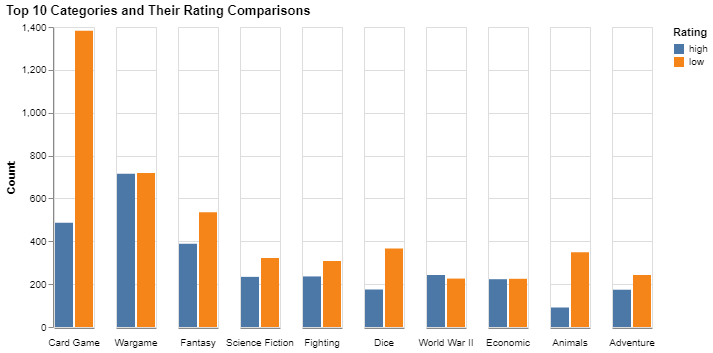

In [20]:
alt.Chart(
    category_long.query("category in @top_10_categories"),
    title = "Top 10 Categories and Their Rating Comparisons"
).mark_bar().encode(
    x = alt.X("rating", axis=alt.Axis(title=None, labels=False, ticks=False)),
    y = alt.Y("value", title="Count"),
    column = alt.Column('category', header=alt.Header(title=None, labelOrient='bottom'), sort=top_10_categories),
    color = alt.Color("rating", title="Rating")
)

**Figure 5: Bar plot comparing the number of occurrences of the top 10 most frequent boardgame categories**

Looking at the bar chart, we can see that there does not appear to be any boardgame category that have significantly more high ratings than low ratings. Ratings lower than 7 are more common than those higher than 7. It appears that the "Wargame" category has equal number of games with high and low ratings.

<br>

In [21]:
# Applying MultiLabelBinarizer and grouping the columns by rating to get the number of occurrences for each value, then 
# transforming the DataFrame into long format to plot
mlb = MultiLabelBinarizer()
mechanic_trans = mlb.fit_transform(binarized_rating_df["boardgamemechanic"])
mechanic_count_df = pd.concat([pd.DataFrame(mechanic_trans, columns=mlb.classes_), binarized_rating_df["rating"].reset_index()], axis=1)
top_10_mechanics = mechanic_count_df.sum(numeric_only=True).sort_values(ascending=False)[1:11].index.tolist()
mechanic_grouped = mechanic_count_df.groupby("rating").sum().T
mechanic_grouped["mechanic"] = mechanic_grouped.index
mechanic_grouped.reset_index(drop=True)
mechanic_long = mechanic_grouped.melt("mechanic")

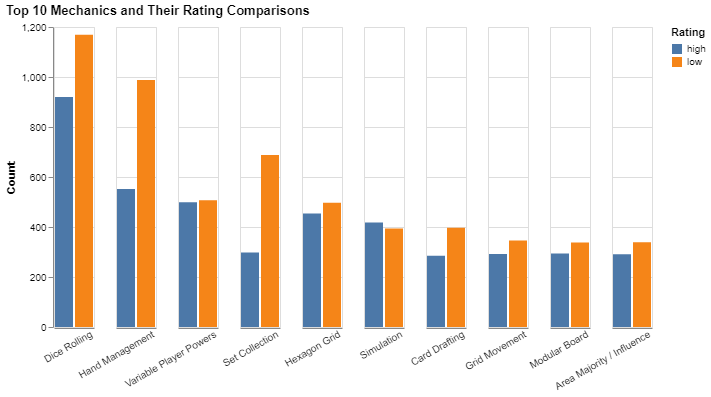

In [22]:
alt.Chart(
    mechanic_long.query("mechanic in @top_10_mechanics"),
    title = "Top 10 Mechanics and Their Rating Comparisons"
).mark_bar().encode(
    alt.X("rating", axis=alt.Axis(title=None, labels=False, ticks=False)),
    alt.Y("value", title="Count"),
    column = alt.Column('mechanic', header=alt.Header(title=None, labelOrient='bottom', labelAngle=330, labelAnchor="end"), sort=top_10_mechanics),
    color = alt.Color("rating", title="Rating")
)

**Figure 6: Bar plot comparing the number of occurrences of the top 10 most frequent boardgame mechanics**

Looking at the bar chart, we can see that again ratings lower than 7 are more common and there does not appear to be a boardgame mechanic that correlates to higher ratings. However, it appears that the boardgame mechanic "Variable Player Powers" have near equal number of games with high and low ratings.

<br>

In [23]:
# Applying MultiLabelBinarizer and grouping the columns by rating to get the number of occurrences for each value, then 
# transforming the DataFrame into long format to plot
mlb = MultiLabelBinarizer()
family_trans = mlb.fit_transform(binarized_rating_df["boardgamefamily"])
family_count_df = pd.concat([pd.DataFrame(family_trans, columns=mlb.classes_), binarized_rating_df["rating"].reset_index()], axis=1)
top_10_families = family_count_df.sum(numeric_only=True).sort_values(ascending=False)[1:11].index.tolist()
family_grouped = family_count_df.groupby("rating").sum().T
family_grouped["family"] = family_grouped.index
family_grouped.reset_index(drop=True)
family_long = family_grouped.melt("family")

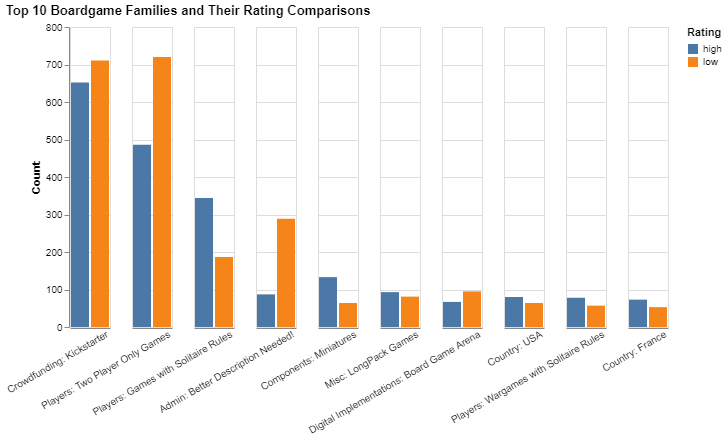

In [24]:
alt.Chart(
    family_long.query("family in @top_10_families"),
    title = "Top 10 Boardgame Families and Their Rating Comparisons"
).mark_bar().encode(
    alt.X("rating", axis=alt.Axis(title=None, labels=False, ticks=False)),
    alt.Y("value", title="Count"),
    column = alt.Column('family', header=alt.Header(title=None, labelOrient='bottom', labelAngle=330, labelAnchor="end"), sort=top_10_families),
    color = alt.Color("rating", title="Rating")
)

**Figure 7: Bar plot comparing the number of occurrences of the top 10 most frequent boardgame families**

Looking at the bar chart, we can see that the boardgame family "Players: Games with Solitaire Rules" and "Components: Miniatures" appear to have more games with high ratings than low ratings. However, we also see that there appears to be a placeholder value for the boardgame family, as one of the most frequently occurring value is "Admin: Better Description Needed!".

<br>

**References**  
BoardGameGeek, LLC. 2022. "Board Games". Retrieved November 16, 2022 from github.com/rfordatascience/tidytuesday/tree/master/data/2022/2022-01-25.